In [18]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
sys.path.append(os.path.abspath('../../'))

from core.taa.features.pipeline import FeaturePipeline
from core.taa.model_engine import TAAModelEngine

%matplotlib inline
sns.set_style('whitegrid')

## 1. Load Features from Previous Step

In [29]:
# Generate features (or load from cache)
tickers = ['SPY', 'XLK', 'XLE', 'XLF', 'XLV', 'XLI', 'XLP', 'XLY', 'XLU']
benchmark = 'ACWI'

pipeline = FeaturePipeline()
df_features = pipeline.run(
    tickers=tickers,
    benchmark_ticker=benchmark,
    start_date='2010-01-01',
    end_date='2024-12-31'
)

print(f"Features shape: {df_features.shape}")
print(f"Date range: {df_features.index.get_level_values('Date').min()} to {df_features.index.get_level_values('Date').max()}")
print(df_features.head())

Features shape: (33957, 16)
Date range: 2010-01-04 00:00:00 to 2024-12-30 00:00:00
                   MOM_1W  MOM_4W  MOM_12W  MOM_52W  VOL_20D  VOL_60D  \
Date       ticker                                                       
2010-01-04 SPY        NaN     NaN      NaN      NaN      NaN      NaN   
           XLE        NaN     NaN      NaN      NaN      NaN      NaN   
           XLF        NaN     NaN      NaN      NaN      NaN      NaN   
           XLI        NaN     NaN      NaN      NaN      NaN      NaN   
           XLK        NaN     NaN      NaN      NaN      NaN      NaN   

                   DIST_SMA200  RSI_14  REL_MOM_4W  REL_MOM_12W  REL_RSI  \
Date       ticker                                                          
2010-01-04 SPY             NaN     NaN         NaN          NaN      NaN   
           XLE             NaN     NaN         NaN          NaN      NaN   
           XLF             NaN     NaN         NaN          NaN      NaN   
           XLI           

## 2. Add Price Data for Target Calculation

In [31]:
# Pipeline already fetches price data internally
# We just need to add Close prices to the feature dataframe for target calculation
from core.data.collectors import YahooCollector

yahoo = YahooCollector()
prices_df = yahoo.fetch_history(tickers, '2010-01-01', '2024-12-31')
print(f"Prices: {prices_df}")
# Extract Close prices and align to feature index
close_prices = []
for ticker in tickers:
    ticker_prices = prices_df.xs(ticker, axis=1, level=0)['Close']
    ticker_prices.name = 'Close'
    ticker_df = pd.DataFrame({'Close': ticker_prices})
    ticker_df['ticker'] = ticker
    ticker_df = ticker_df.reset_index().rename(columns={'index': 'Date'})
    ticker_df = ticker_df.set_index(['Date', 'ticker'])
    close_prices.append(ticker_df)

close_df = pd.concat(close_prices).sort_index()

# Merge with features
df_full = df_features.join(close_df, how='left')
print(f"Full data shape: {df_full.shape}")
display(df_full.head())

Prices: Ticker            XLP                                                   XLU  \
Price            Open       High        Low      Close    Volume       Open   
Date                                                                          
2010-01-04  17.204770  17.419423  17.204770  17.347872   8465900   9.005803   
2010-01-05  17.360883  17.380396  17.263313  17.354378  11805400   8.922310   
2010-01-06  17.334863  17.360882  17.263313  17.341368   9267000   8.835938   
2010-01-07  17.393405  17.393405  17.243798  17.341368   6951500   8.882001   
2010-01-08  17.302344  17.302344  17.185260  17.282829   5437400   8.841696   
...               ...        ...        ...        ...       ...        ...   
2024-12-23  76.948150  77.123364  76.081815  76.821602  11469000  36.755104   
2024-12-24  76.753450  77.376433  76.646374  77.327766   3932600  36.973853   
2024-12-26  77.181763  77.619795  77.113624  77.571129   4253700  37.022467   
2024-12-27  77.210963  77.600329  76.909208 

MOM_1W  MOM_4W  MOM_12W  MOM_52W  VOL_20D  VOL_60D  \
Date       ticker                                                       
2010-01-04 SPY        NaN     NaN      NaN      NaN      NaN      NaN   
           XLE        NaN     NaN      NaN      NaN      NaN      NaN   
           XLF        NaN     NaN      NaN      NaN      NaN      NaN   
           XLI        NaN     NaN      NaN      NaN      NaN      NaN   
           XLK        NaN     NaN      NaN      NaN      NaN      NaN   

                   DIST_SMA200  RSI_14  REL_MOM_4W  REL_MOM_12W  REL_RSI  \
Date       ticker                                                          
2010-01-04 SPY             NaN     NaN         NaN          NaN      NaN   
           XLE             NaN     NaN         NaN          NaN      NaN   
           XLF             NaN     NaN         NaN          NaN      NaN   
           XLI             NaN     NaN         NaN          NaN      NaN   
           XLK             NaN     NaN         NaN          NaN      NaN   

                   BETA_60D  YIELD_CURVE_SLOPE  CREDIT_SPREAD    VIX  CPI_YOY  \
Date       ticker                                                               
2010-01-04 SPY          NaN               2.76           2.54  20.04      NaN   
           XLE          NaN               2.76           2.54  20.04      NaN   
           XLF          NaN               2.76           2.54  20.04      NaN   
           XLI          NaN               2.76           2.54  20.04      NaN   
           XLK          NaN               2.76           2.54  20.04      NaN   

                       Close  
Date       ticker             
2010-01-04 SPY     85.027939  
           XLE     17.381088  
           XLF      8.988354  
           XLI     20.981585  
           XLK      9.390443

## 3. Create Forward Return Targets


Target Statistics:


,target_1w,target_4w,target_12w
count,33912.000000,33777.000000,33417.000000
mean,0.002668,0.010786,0.032078
std,0.026532,0.050782,0.080376
min,-0.345547,-0.562808,-0.599450
25%,-0.009938,-0.014752,-0.008576
50%,0.003956,0.013951,0.036400
75%,0.016626,0.038841,0.077381
max,0.285110,0.420786,0.697708


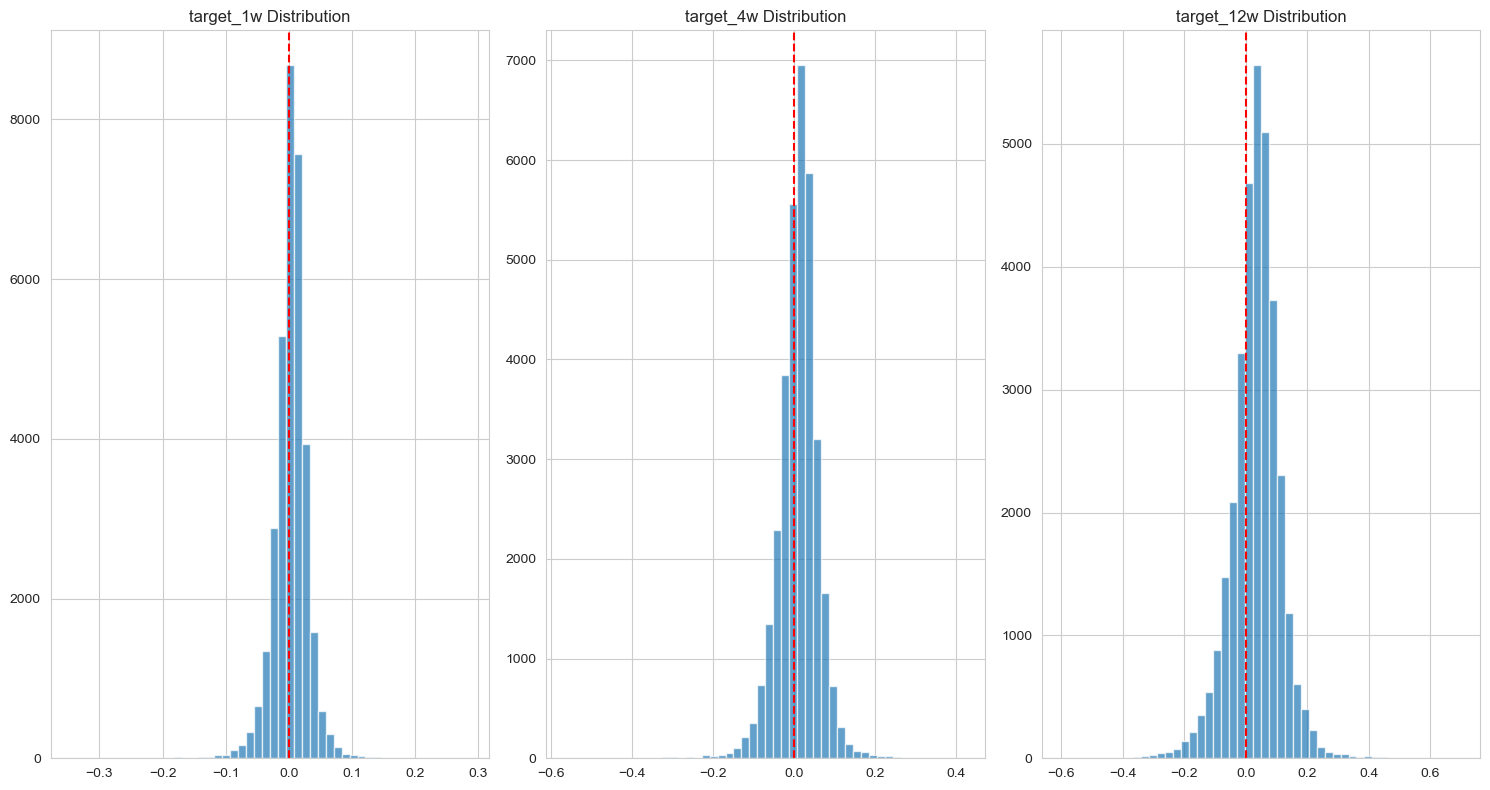

In [32]:
# Initialize model engine
engine = TAAModelEngine(horizons=[1, 4, 12])

# Create targets
df_with_targets = engine.create_targets(df_full, price_col='Close')

# Check target distribution
target_cols = ['target_1w', 'target_4w', 'target_12w']
print("\nTarget Statistics:")
display(df_with_targets[target_cols].describe())

# Plot target distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
for i, col in enumerate(target_cols):
    df_with_targets[col].hist(bins=50, ax=axes[i], alpha=0.7)
    axes[i].set_title(f'{col} Distribution')
    axes[i].axvline(0, color='red', linestyle='--')
plt.tight_layout()

## 4. Train Models

In [33]:
# Auto-detect feature columns (exclude targets and price columns)
exclude_cols = target_cols + ['Close', 'Open', 'High', 'Low', 'Volume']
feature_cols = [c for c in df_with_targets.columns if c not in exclude_cols]

print(f"Training with {len(feature_cols)} features")
print(f"Features: {feature_cols}\n")

# Train models
results = engine.train(
    data=df_with_targets,
    feature_cols=feature_cols,
    val_split=0.2,
    verbose=True
)

Training with 16 features
Features: ['MOM_1W', 'MOM_4W', 'MOM_12W', 'MOM_52W', 'VOL_20D', 'VOL_60D', 'DIST_SMA200', 'RSI_14', 'REL_MOM_4W', 'REL_MOM_12W', 'REL_RSI', 'BETA_60D', 'YIELD_CURVE_SLOPE', 'CREDIT_SPREAD', 'VIX', 'CPI_YOY']

[0]	validation_0-rmse:0.02798
[1]	validation_0-rmse:0.02767
[2]	validation_0-rmse:0.02737
[3]	validation_0-rmse:0.02713
[1]	validation_0-rmse:0.02767
[2]	validation_0-rmse:0.02737
[3]	validation_0-rmse:0.02713
[4]	validation_0-rmse:0.02706
[5]	validation_0-rmse:0.02682
[6]	validation_0-rmse:0.02662
[7]	validation_0-rmse:0.02641
[4]	validation_0-rmse:0.02706
[5]	validation_0-rmse:0.02682
[6]	validation_0-rmse:0.02662
[7]	validation_0-rmse:0.02641
[8]	validation_0-rmse:0.02637
[9]	validation_0-rmse:0.02618
[10]	validation_0-rmse:0.02614
[11]	validation_0-rmse:0.02598
[12]	validation_0-rmse:0.02585
[8]	validation_0-rmse:0.02637
[9]	validation_0-rmse:0.02618
[10]	validation_0-rmse:0.02614
[11]	validation_0-rmse:0.02598
[12]	validation_0-rmse:0.02585
[13]	vali

## 5. Evaluate Model Performance

In [23]:
# Display results
results_df = pd.DataFrame(results).T
results_df.index.name = 'horizon'
print("\nModel Performance Summary:")
display(results_df[['train_ic', 'val_ic', 'train_samples', 'val_samples']])


Model Performance Summary:


,train_ic,val_ic,train_samples,val_samples
horizon,,,,
1,0.579472,0.528124,25347,6337
4,0.715729,0.5929,25335,6334
12,0.771517,0.43436,25303,6326


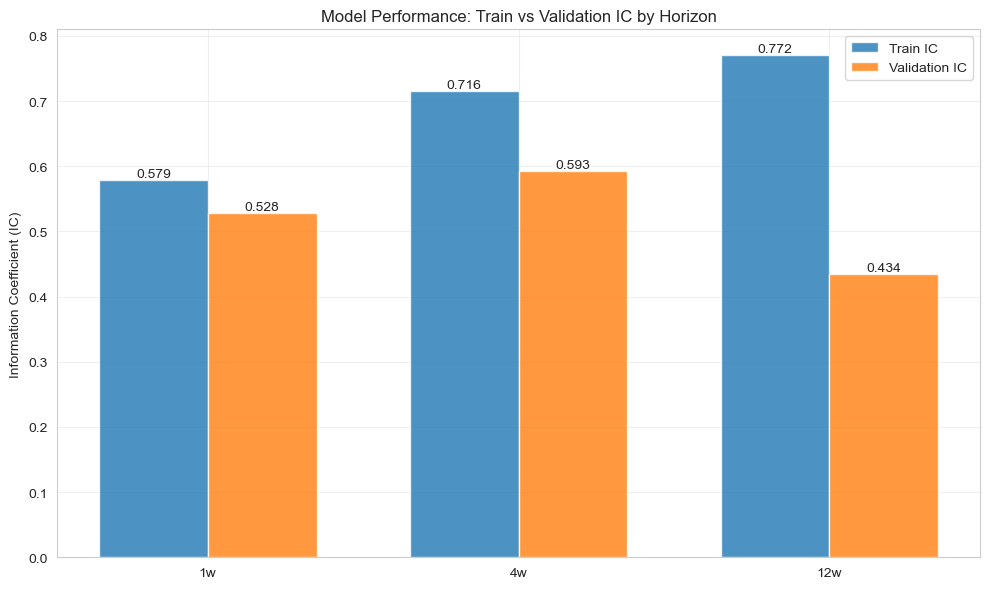


Overfitting Analysis:
1w: Train=0.579, Val=0.528, Gap=0.051, Ratio=91.14% → ✓ Good
4w: Train=0.716, Val=0.593, Gap=0.123, Ratio=82.84% → ⚠ Overfitting
12w: Train=0.772, Val=0.434, Gap=0.337, Ratio=56.30% → ✗ Severe Overfitting


In [34]:
# Visualize Train vs Val IC to check for overfitting
horizons = [1, 4, 12]
train_ics = [results[h]['train_ic'] for h in horizons]
val_ics = [results[h]['val_ic'] for h in horizons]

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(horizons))
width = 0.35

bars1 = ax.bar(x - width/2, train_ics, width, label='Train IC', alpha=0.8)
bars2 = ax.bar(x + width/2, val_ics, width, label='Validation IC', alpha=0.8)

ax.set_ylabel('Information Coefficient (IC)')
ax.set_title('Model Performance: Train vs Validation IC by Horizon')
ax.set_xticks(x)
ax.set_xticklabels([f'{h}w' for h in horizons])
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Calculate overfitting ratio
print("\nOverfitting Analysis:")
for h in horizons:
    train_ic = results[h]['train_ic']
    val_ic = results[h]['val_ic']
    gap = train_ic - val_ic
    ratio = val_ic / train_ic if train_ic != 0 else 0
    
    status = "✓ Good" if gap < 0.10 else "⚠ Overfitting" if gap < 0.20 else "✗ Severe Overfitting"
    print(f"{h}w: Train={train_ic:.3f}, Val={val_ic:.3f}, Gap={gap:.3f}, Ratio={ratio:.2%} → {status}")


Top 15 Features for 1w Horizon


,feature,importance
0,MOM_1W,0.165544
7,RSI_14,0.146536
14,VIX,0.085254
4,VOL_20D,0.079411
12,YIELD_CURVE_SLOPE,0.077096
13,CREDIT_SPREAD,0.075642
5,VOL_60D,0.072083
15,CPI_YOY,0.065254
8,REL_MOM_4W,0.061263
1,MOM_4W,0.059974


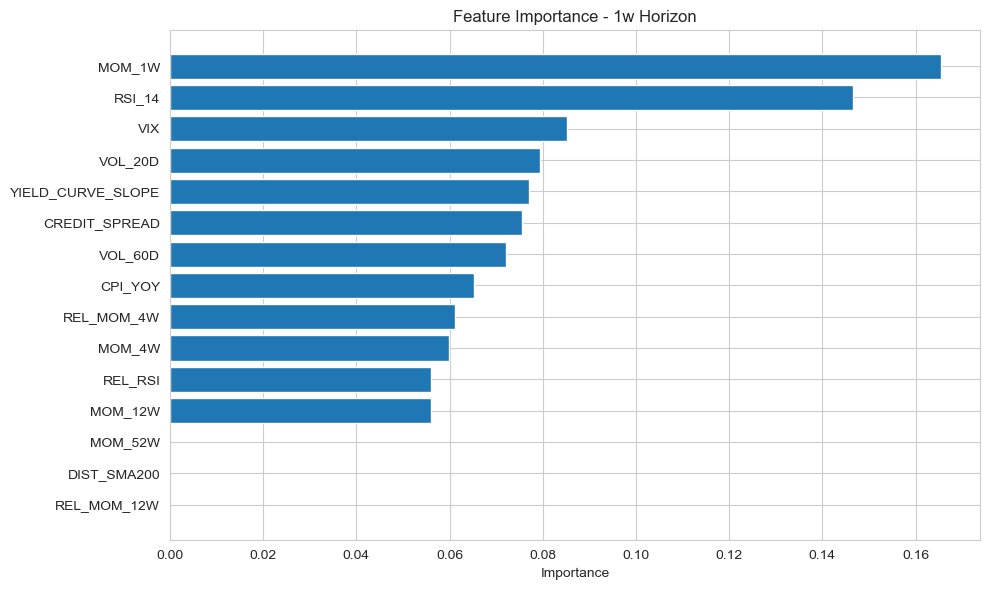


Top 15 Features for 4w Horizon


,feature,importance
14,VIX,0.205550
1,MOM_4W,0.112204
7,RSI_14,0.088449
5,VOL_60D,0.088076
0,MOM_1W,0.073885
4,VOL_20D,0.053456
8,REL_MOM_4W,0.051399
12,YIELD_CURVE_SLOPE,0.050315
15,CPI_YOY,0.047289
10,REL_RSI,0.038822


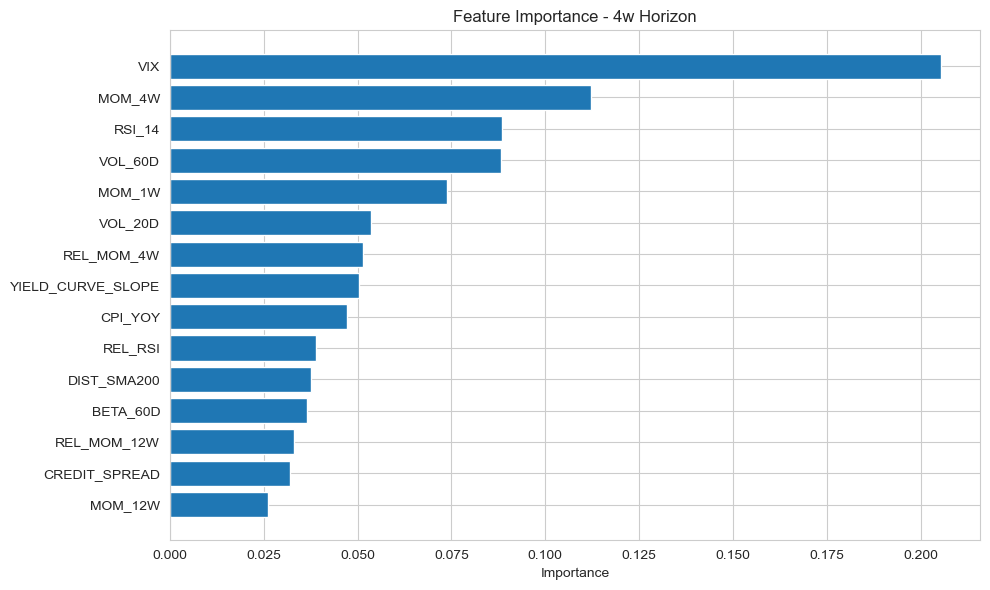


Top 15 Features for 12w Horizon


,feature,importance
14,VIX,0.213709
2,MOM_12W,0.136191
9,REL_MOM_12W,0.102538
15,CPI_YOY,0.064420
13,CREDIT_SPREAD,0.059809
4,VOL_20D,0.051824
5,VOL_60D,0.048901
1,MOM_4W,0.047206
12,YIELD_CURVE_SLOPE,0.046778
8,REL_MOM_4W,0.041934


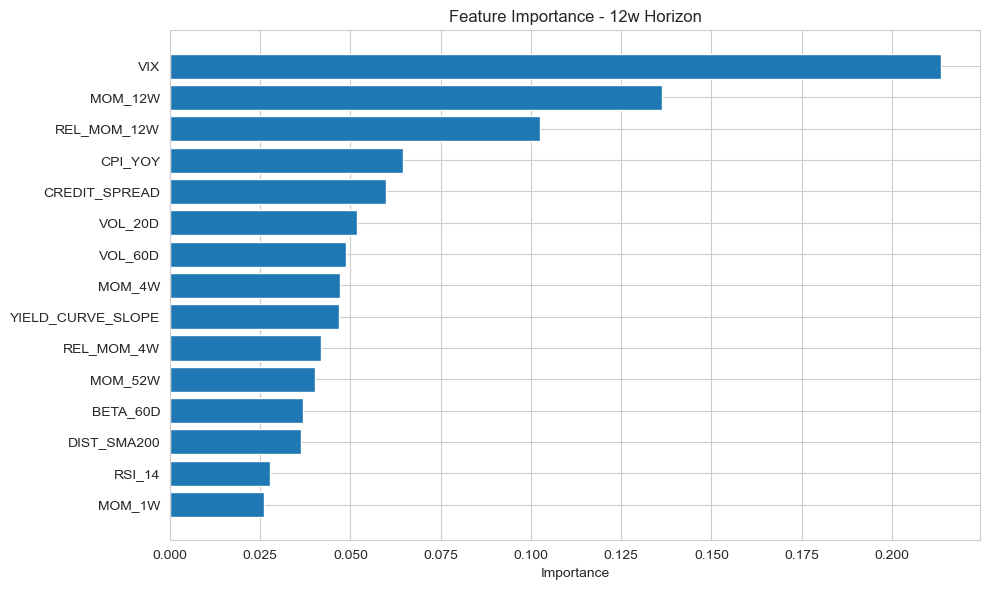

In [35]:
# Feature importance for each horizon
for horizon in [1, 4, 12]:
    print(f"\n{'='*60}")
    print(f"Top 15 Features for {horizon}w Horizon")
    print('='*60)
    importance = engine.get_feature_importance(horizon, top_n=15)
    display(importance)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(importance['feature'], importance['importance'])
    plt.xlabel('Importance')
    plt.title(f'Feature Importance - {horizon}w Horizon')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## 6. Generate Predictions

In [26]:
# Generate predictions
df_predictions = engine.predict(df_with_targets, feature_cols=feature_cols)

# Show predictions
pred_cols = ['pred_1w', 'pred_4w', 'pred_12w']
display(df_predictions[target_cols + pred_cols].tail(20))

target_1w  target_4w  target_12w   pred_1w   pred_4w  \
Date       ticker                                                         
2024-12-26 XLV      0.012554        NaN         NaN  0.007658  0.001394   
           XLY      0.023180        NaN         NaN  0.008429  0.010027   
2024-12-27 SPY      0.003034        NaN         NaN  0.007985 -0.005613   
           XLE      0.019677        NaN         NaN  0.008556 -0.000088   
           XLF      0.024208        NaN         NaN  0.008984 -0.009042   
           XLI      0.008082        NaN         NaN  0.004891  0.004669   
           XLK     -0.004957        NaN         NaN  0.008967 -0.000873   
           XLP      0.013303        NaN         NaN  0.000770  0.001842   
           XLU     -0.000497        NaN         NaN  0.007658 -0.000573   
           XLV     -0.009238        NaN         NaN  0.008984 -0.004532   
           XLY     -0.004686        NaN         NaN  0.004627  0.006854   
2024-12-30 SPY     -0.012201        NaN         NaN -0.001560 -0.014123   
           XLE     -0.000554        NaN         NaN  0.004959 -0.006397   
           XLF     -0.001004        NaN         NaN  0.001129 -0.018784   
           XLI     -0.010623        NaN         NaN -0.000158 -0.003967   
           XLK           NaN        NaN         NaN -0.001299 -0.010056   
           XLP           NaN        NaN         NaN -0.005140 -0.013852   
           XLU           NaN        NaN         NaN  0.001496 -0.006356   
           XLV           NaN        NaN         NaN  0.001629 -0.016525   
           XLY           NaN        NaN         NaN -0.001379 -0.002768   

                   pred_12w  
Date       ticker            
2024-12-26 XLV     0.046406  
           XLY     0.022461  
2024-12-27 SPY     0.030173  
           XLE     0.029730  
           XLF     0.033211  
           XLI     0.032599  
           XLK     0.029659  
           XLP     0.043845  
           XLU     0.038402  
           XLV     0.033130  
           XLY     0.008541  
2024-12-30 SPY     0.022338  
           XLE     0.018768  
           XLF     0.026424  
           XLI     0.028285  
           XLK     0.011064  
           XLP     0.036690  
           XLU     0.031979  
           XLV     0.027381  
           XLY     0.007278

## 7. Analyze Prediction Quality

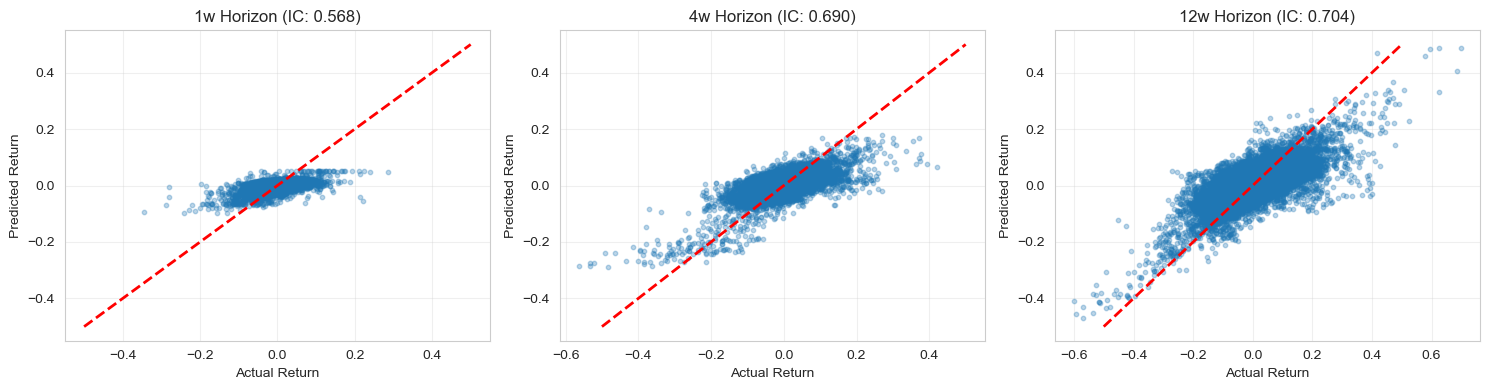

In [36]:
# Scatter plots: Actual vs Predicted
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, horizon in enumerate([1, 4, 12]):
    target_col = f'target_{horizon}w'
    pred_col = f'pred_{horizon}w'
    
    # Get valid data
    valid_data = df_predictions[[target_col, pred_col]].dropna()
    
    # Scatter plot
    axes[i].scatter(valid_data[target_col], valid_data[pred_col], alpha=0.3, s=10)
    axes[i].plot([-0.5, 0.5], [-0.5, 0.5], 'r--', lw=2)  # Perfect prediction line
    
    # Calculate IC
    ic = np.corrcoef(valid_data[target_col], valid_data[pred_col])[0, 1]
    axes[i].set_title(f'{horizon}w Horizon (IC: {ic:.3f})')
    axes[i].set_xlabel('Actual Return')
    axes[i].set_ylabel('Predicted Return')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Time Series of Predictions (Latest Date)


Latest Predictions (2024-12-30):


,pred_1w,pred_4w,pred_12w
ticker,,,
XLP,-0.005140,-0.013852,0.036690
XLU,0.001496,-0.006356,0.031979
XLI,-0.000158,-0.003967,0.028285
XLV,0.001629,-0.016525,0.027381
XLF,0.001129,-0.018784,0.026424
SPY,-0.001560,-0.014123,0.022338
XLE,0.004959,-0.006397,0.018768
XLK,-0.001299,-0.010056,0.011064
XLY,-0.001379,-0.002768,0.007278


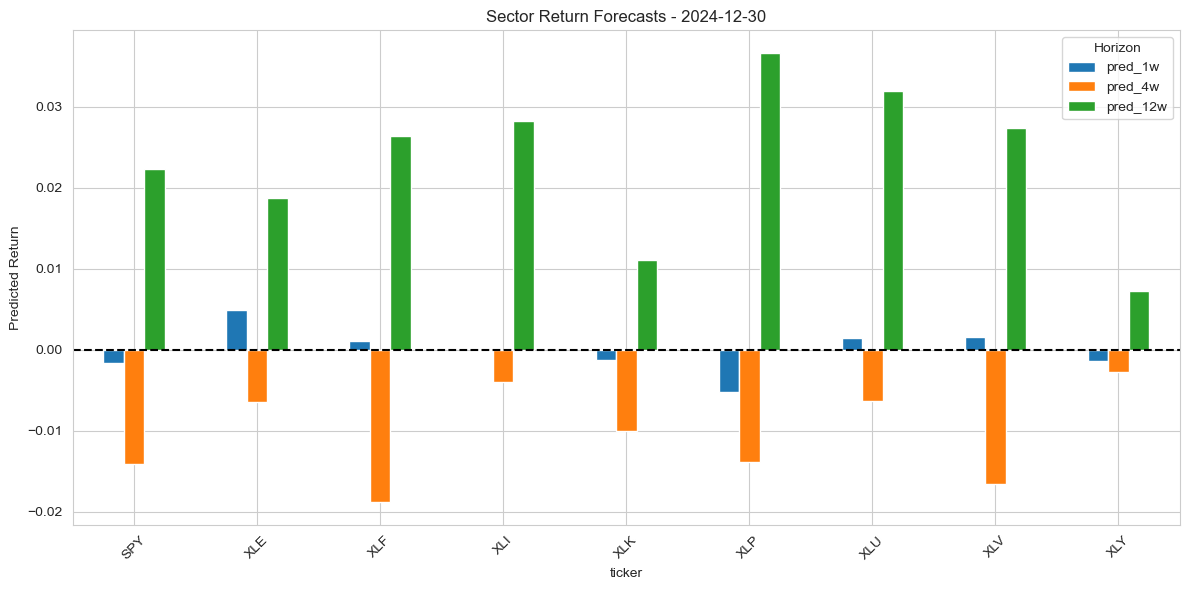

In [37]:
# Get latest predictions for each ticker
latest_date = df_predictions.index.get_level_values('Date').max()
latest_preds = df_predictions.xs(latest_date, level='Date')[pred_cols]

print(f"\nLatest Predictions ({latest_date.date()}):")
display(latest_preds.sort_values('pred_12w', ascending=False))

# Visualize
latest_preds.plot(kind='bar', figsize=(12, 6))
plt.title(f'Sector Return Forecasts - {latest_date.date()}')
plt.ylabel('Predicted Return')
plt.axhline(0, color='black', linestyle='--')
plt.legend(title='Horizon')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()